## House Price Prediction Using Machine Learning 

**Dataset:** California Housing Prices - `housing.csv`

**Kaggle link:** https://www.kaggle.com/datasets/camnugent/california-housing-prices

> Process: EDA → preprocessing → baseline model → model selection (CV) → tuning (GridSearchCV) → final evaluation → inference.

**1. Setup**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [2]:
# configurations
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:.3f}")
sns.set_theme(style="darkgrid")

plt.rcParams.update({
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
})

RANDOM_STATE = 42
CSV_PATH = "housing.csv"
TARGET_COL = "median_house_value" 

**2. Load Dataset** 

In [3]:
df = pd.read_csv(CSV_PATH)

In [4]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.230,37.880,41.000,880.000,129.000,322.000,126.000,8.325,452600.000,NEAR BAY
1,-122.220,37.860,21.000,7099.000,1106.000,2401.000,1138.000,8.301,358500.000,NEAR BAY
2,-122.240,37.850,52.000,1467.000,190.000,496.000,177.000,7.257,352100.000,NEAR BAY
3,-122.250,37.850,52.000,1274.000,235.000,558.000,219.000,5.643,341300.000,NEAR BAY
4,-122.250,37.850,52.000,1627.000,280.000,565.000,259.000,3.846,342200.000,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.090,39.480,25.000,1665.000,374.000,845.000,330.000,1.560,78100.000,INLAND
20636,-121.210,39.490,18.000,697.000,150.000,356.000,114.000,2.557,77100.000,INLAND
20637,-121.220,39.430,17.000,2254.000,485.000,1007.000,433.000,1.700,92300.000,INLAND
20638,-121.320,39.430,18.000,1860.000,409.000,741.000,349.000,1.867,84700.000,INLAND


In [5]:
print("Data Frame shape: ", df.shape)

Data Frame shape:  (20640, 10)


In [6]:
# Printing top 5 rows of the data frame
df.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.230,37.880,41.000,880.000,129.000,322.000,126.000,8.325,452600.000,NEAR BAY
1,-122.220,37.860,21.000,7099.000,1106.000,2401.000,1138.000,8.301,358500.000,NEAR BAY
2,-122.240,37.850,52.000,1467.000,190.000,496.000,177.000,7.257,352100.000,NEAR BAY
3,-122.250,37.850,52.000,1274.000,235.000,558.000,219.000,5.643,341300.000,NEAR BAY
4,-122.250,37.850,52.000,1627.000,280.000,565.000,259.000,3.846,342200.000,NEAR BAY


In [7]:
# Printing bottom 5 rows of the data frame
df.tail(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20635,-121.090,39.480,25.000,1665.000,374.000,845.000,330.000,1.560,78100.000,INLAND
20636,-121.210,39.490,18.000,697.000,150.000,356.000,114.000,2.557,77100.000,INLAND
20637,-121.220,39.430,17.000,2254.000,485.000,1007.000,433.000,1.700,92300.000,INLAND
20638,-121.320,39.430,18.000,1860.000,409.000,741.000,349.000,1.867,84700.000,INLAND
20639,-121.240,39.370,16.000,2785.000,616.000,1387.000,530.000,2.389,89400.000,INLAND


**3. Exploatory Data Analysis(EDA)**

In [8]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

**Column details:**

1. longitude: A measure of how far west a house is; a higher value is farther west

2. latitude: A measure of how far north a house is; a higher value is farther north

3. housingMedianAge: Median age of a house within a block; a lower number is a newer building

4. totalRooms: Total number of rooms within a block

5. totalBedrooms: Total number of bedrooms within a block

6. population: Total number of people residing within a block

7. households: Total number of households, a group of people residing within a home unit, for a block

8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. medianHouseValue: Median house value for households within a block (measured in US Dollars)

10. oceanProximity: Location of the house w.r.t ocean/sea

In [9]:
# basic dataset overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [10]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("Target column: ", TARGET_COL)
print("Numerical column: ", num_cols)
print("Categorical column: ", cat_cols)

Target column:  median_house_value
Numerical column:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Categorical column:  ['ocean_proximity']


In [11]:
# missing value analysis
print("\nMissing values per column:")
print(df.isna().sum())


Missing values per column:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


**NOTE: total_bedrooms has missing values**

In [12]:
# check presence of encoded missing values
for col in df.columns:
    print(df[col].value_counts().head(20))

longitude
-118.310    162
-118.300    160
-118.290    148
-118.270    144
-118.320    142
-118.280    141
-118.350    140
-118.360    138
-118.190    135
-118.250    128
-118.370    128
-118.200    126
-118.140    125
-118.260    121
-118.130    121
-118.180    120
-118.340    119
-118.210    118
-118.150    116
-118.120    112
Name: count, dtype: int64
latitude
34.060    244
34.050    236
34.080    234
34.070    231
34.040    221
34.090    212
34.020    208
34.100    203
34.030    193
33.930    181
33.940    175
33.970    172
33.990    168
33.880    164
33.980    162
34.110    162
34.160    159
34.120    158
34.150    157
34.010    156
Name: count, dtype: int64
housing_median_age
52.000    1273
36.000     862
35.000     824
16.000     771
17.000     698
34.000     689
26.000     619
33.000     615
18.000     570
25.000     566
32.000     565
37.000     537
15.000     512
19.000     502
27.000     488
24.000     478
30.000     476
28.000     471
20.000     465
29.000     461
Name: coun

In [13]:
# Duplicates
duplicate_mask = df.duplicated()
num_duplicates = duplicate_mask.sum()
print("Number of duplicated rows: ", num_duplicates)

# drop duplicates if present (otional)
# df = df.drop_duplicates()
# print("Shape after dropping duplicate: ", df.shape)

Number of duplicated rows:  0


In [14]:
# descriptive stat
df[num_cols].describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000,20640.000,20640.000,20640.000,20433.000,20640.000,20640.000,20640.000,20640.000
mean,-119.570,35.632,28.639,2635.763,537.871,1425.477,499.540,3.871,206855.817
std,2.004,2.136,12.586,2181.615,421.385,1132.462,382.330,1.900,115395.616
min,-124.350,32.540,1.000,2.000,1.000,3.000,1.000,0.500,14999.000
25%,-121.800,33.930,18.000,1447.750,296.000,787.000,280.000,2.563,119600.000
50%,-118.490,34.260,29.000,2127.000,435.000,1166.000,409.000,3.535,179700.000
75%,-118.010,37.710,37.000,3148.000,647.000,1725.000,605.000,4.743,264725.000
max,-114.310,41.950,52.000,39320.000,6445.000,35682.000,6082.000,15.000,500001.000


In [15]:
# descriptive stat transpose
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.000,-119.570,2.004,-124.350,-121.800,-118.490,-118.010,-114.310
latitude,20640.000,35.632,2.136,32.540,33.930,34.260,37.710,41.950
housing_median_age,20640.000,28.639,12.586,1.000,18.000,29.000,37.000,52.000
total_rooms,20640.000,2635.763,2181.615,2.000,1447.750,2127.000,3148.000,39320.000
total_bedrooms,20433.000,537.871,421.385,1.000,296.000,435.000,647.000,6445.000
population,20640.000,1425.477,1132.462,3.000,787.000,1166.000,1725.000,35682.000
households,20640.000,499.540,382.330,1.000,280.000,409.000,605.000,6082.000
median_income,20640.000,3.871,1.900,0.500,2.563,3.535,4.743,15.000
median_house_value,20640.000,206855.817,115395.616,14999.000,119600.000,179700.000,264725.000,500001.000


Data Visualization

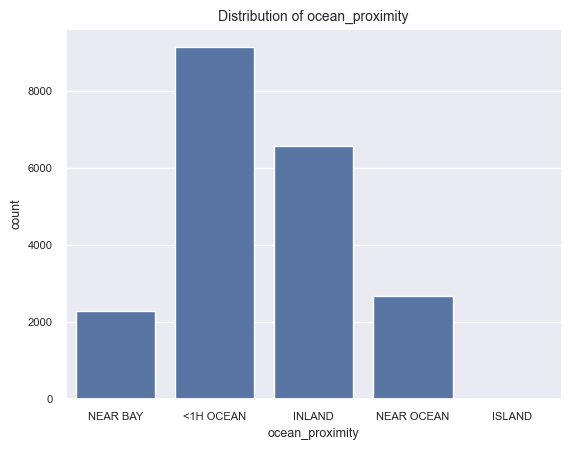

In [16]:
# countplot for categorical columns
for col in cat_cols:
    plt.Figure(figsize=(20, 12))
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.show()

In [17]:
for col in cat_cols:
    print(df[col].value_counts())

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


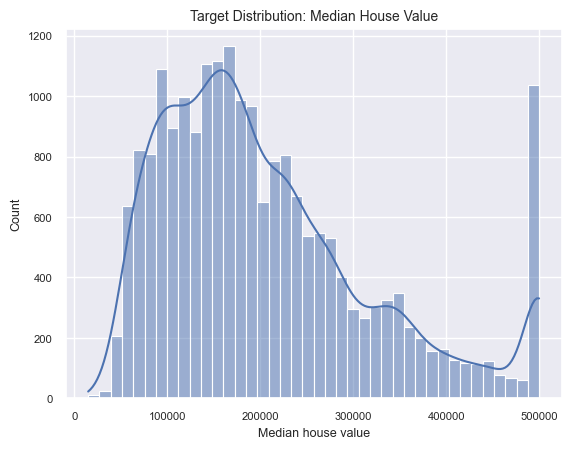

In [18]:
# target column distribution
plt.Figure(figsize=(20, 12))
sns.histplot(df[TARGET_COL], bins=40, kde=True)
plt.title("Target Distribution: Median House Value")
plt.xlabel("Median house value")
plt.show()

In [19]:
df[TARGET_COL].value_counts()

median_house_value
500001.000    965
137500.000    122
162500.000    117
112500.000    103
187500.000     93
             ... 
34200.000       1
46200.000       1
352000.000      1
307900.000      1
385200.000      1
Name: count, Length: 3842, dtype: int64

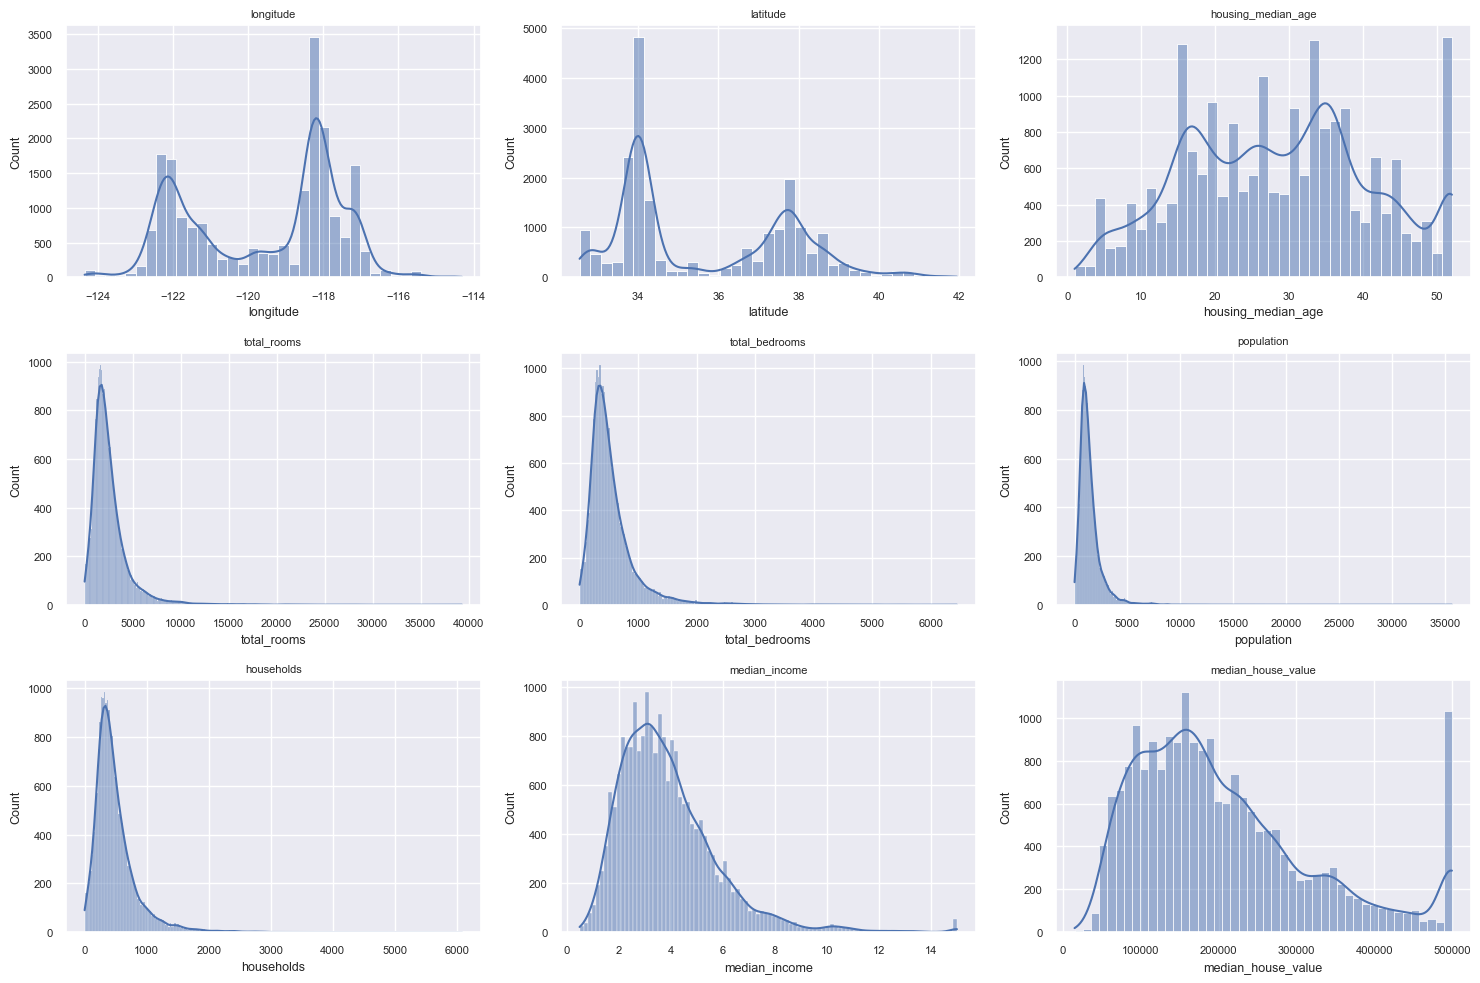

In [20]:
# histogram plot - distribution
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(col, fontsize=8)

plt.tight_layout()
plt.show()

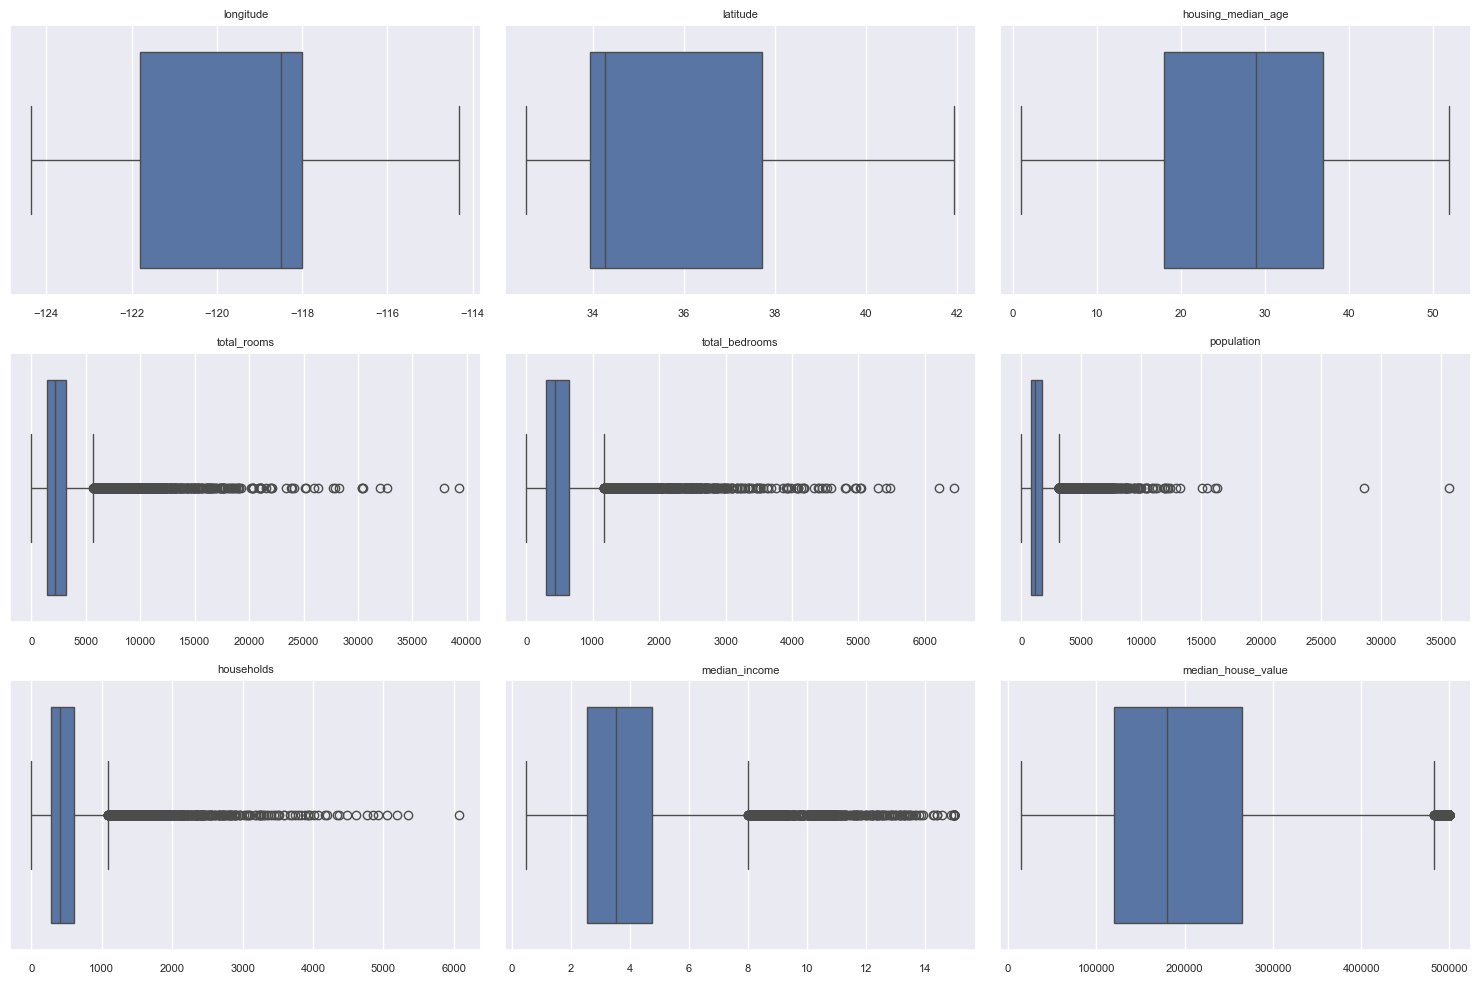

In [21]:
# Outliers analysis - boxplot
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(col, fontsize=8)
    axes[i].set_xlabel("")

plt.tight_layout()
plt.show()

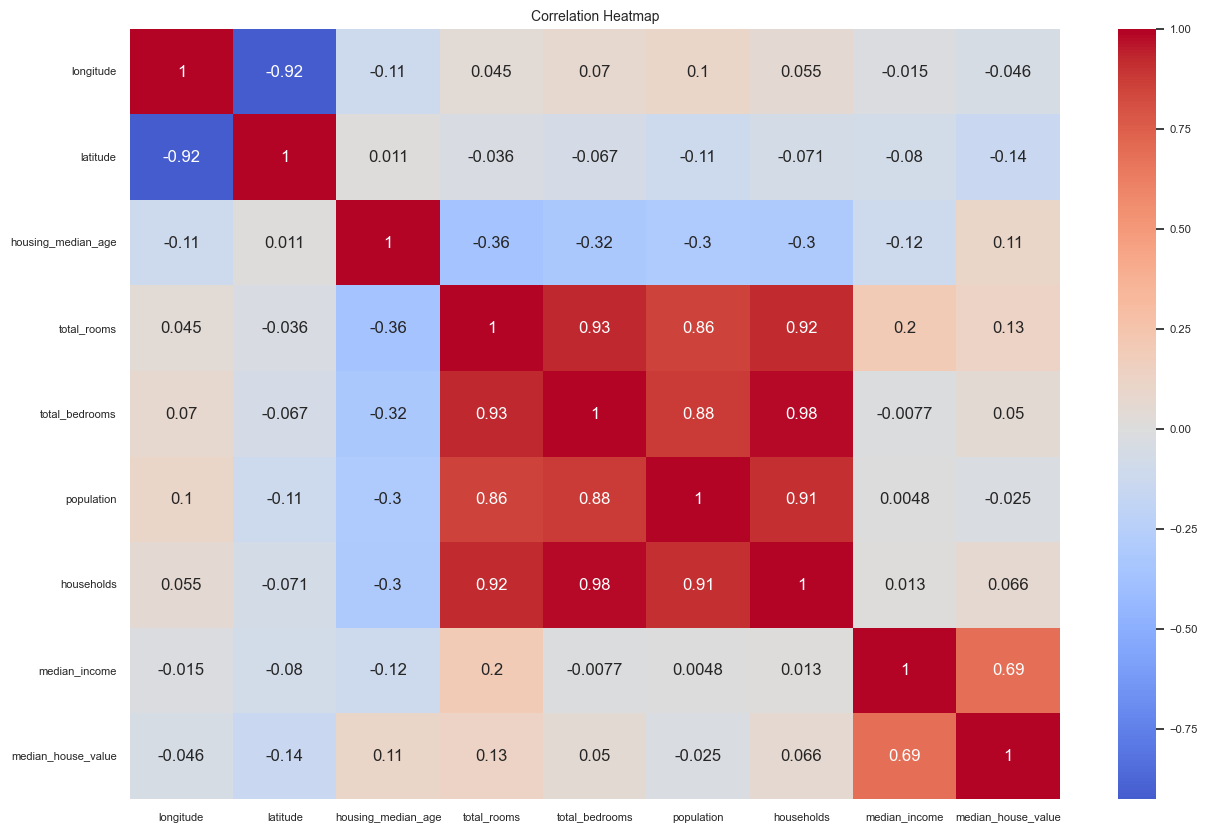

In [22]:
# Identify presence of highly correlated columns & feature relationship
plt.figure(figsize=(15, 10))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

In [23]:
# Correlation with target
corr_with_target = df[num_cols].corr()[TARGET_COL].sort_values(ascending=False)
print("\nCorrelation with target: ")
print(corr_with_target)


Correlation with target: 
median_house_value    1.000
median_income         0.688
total_rooms           0.134
housing_median_age    0.106
households            0.066
total_bedrooms        0.050
population           -0.025
longitude            -0.046
latitude             -0.144
Name: median_house_value, dtype: float64


---

🔍 Key Insights from EDA
- Dataset has numeric + one categorical feature (ocean_proximity)
- Only total_bedrooms has missing values
- Target (median_house_value) is right-skewed and capped
- Several features show strong skew and outliers
- median_income is the strongest predictor
- High multicollinearity among room and population features

⸻

🛠️ Preprocessing & Evaluation Plan
- Median imputation for missing values
- One-hot encoding for categorical feature
- Feature scaling for linear models
- Use pipelines to avoid data leakage
- Baseline model → CV model selection → hyperparameter tuning
- Primary metric: RMSE, secondary: MAE and R²
- Final evaluation only on test set


---

**4. Data Preprocessing**

In [24]:
# Seperate features and target
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

In [25]:
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.230,37.880,41.000,880.000,129.000,322.000,126.000,8.325,NEAR BAY
1,-122.220,37.860,21.000,7099.000,1106.000,2401.000,1138.000,8.301,NEAR BAY
2,-122.240,37.850,52.000,1467.000,190.000,496.000,177.000,7.257,NEAR BAY
3,-122.250,37.850,52.000,1274.000,235.000,558.000,219.000,5.643,NEAR BAY
4,-122.250,37.850,52.000,1627.000,280.000,565.000,259.000,3.846,NEAR BAY
...,...,...,...,...,...,...,...,...,...
20635,-121.090,39.480,25.000,1665.000,374.000,845.000,330.000,1.560,INLAND
20636,-121.210,39.490,18.000,697.000,150.000,356.000,114.000,2.557,INLAND
20637,-121.220,39.430,17.000,2254.000,485.000,1007.000,433.000,1.700,INLAND
20638,-121.320,39.430,18.000,1860.000,409.000,741.000,349.000,1.867,INLAND


In [26]:
y

0       452600.000
1       358500.000
2       352100.000
3       341300.000
4       342200.000
           ...    
20635    78100.000
20636    77100.000
20637    92300.000
20638    84700.000
20639    89400.000
Name: median_house_value, Length: 20640, dtype: float64

In [27]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [28]:
X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14196,-117.030,32.710,33.000,3126.000,627.000,2300.000,623.000,3.260,NEAR OCEAN
8267,-118.160,33.770,49.000,3382.000,787.000,1314.000,756.000,3.812,NEAR OCEAN
17445,-120.480,34.660,4.000,1897.000,331.000,915.000,336.000,4.156,NEAR OCEAN
14265,-117.110,32.690,36.000,1421.000,367.000,1418.000,355.000,1.942,NEAR OCEAN
2271,-119.800,36.780,43.000,2382.000,431.000,874.000,380.000,3.554,INLAND
...,...,...,...,...,...,...,...,...,...
11284,-117.960,33.780,35.000,1330.000,201.000,658.000,217.000,6.370,<1H OCEAN
11964,-117.430,34.020,33.000,3084.000,570.000,1753.000,449.000,3.050,INLAND
5390,-118.380,34.030,36.000,2101.000,569.000,1756.000,527.000,2.934,<1H OCEAN
860,-121.960,37.580,15.000,3575.000,597.000,1777.000,559.000,5.719,<1H OCEAN


In [29]:
X_test

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
20046,-119.010,36.060,25.000,1505.000,NaN,1392.000,359.000,1.681,INLAND
3024,-119.460,35.140,30.000,2943.000,NaN,1565.000,584.000,2.531,INLAND
15663,-122.440,37.800,52.000,3830.000,NaN,1310.000,963.000,3.480,NEAR BAY
20484,-118.720,34.280,17.000,3051.000,NaN,1705.000,495.000,5.738,<1H OCEAN
9814,-121.930,36.620,34.000,2351.000,NaN,1063.000,428.000,3.725,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...
15362,-117.220,33.360,16.000,3165.000,482.000,1351.000,452.000,4.605,<1H OCEAN
16623,-120.830,35.360,28.000,4323.000,886.000,1650.000,705.000,2.727,NEAR OCEAN
18086,-122.050,37.310,25.000,4111.000,538.000,1585.000,568.000,9.230,<1H OCEAN
2144,-119.760,36.770,36.000,2507.000,466.000,1227.000,474.000,2.785,INLAND


In [30]:
y_train

14196   103000.000
8267    382100.000
17445   172600.000
14265    93400.000
2271     96500.000
           ...    
11284   229200.000
11964    97800.000
5390    222100.000
860     283500.000
15795   325000.000
Name: median_house_value, Length: 16512, dtype: float64

In [31]:
y_test

20046    47700.000
3024     45800.000
15663   500001.000
20484   218600.000
9814    278000.000
           ...    
15362   263300.000
16623   266800.000
18086   500001.000
2144     72300.000
3665    151500.000
Name: median_house_value, Length: 4128, dtype: float64

**Preprocessing Pipeline**

In [32]:
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

In [33]:
numerical_features

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [34]:
categorical_features

['ocean_proximity']

In [35]:
# Numerical features - preprocessing steps
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

# Categorical features - preprocessing steps
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

In [36]:
# preprocessing pipeline
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

**5. Baseline model (No CV, No Tuning)**

In [37]:
baseline_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LinearRegression())
    ]
)

In [38]:
# preprocess the data and train the baseline model
baseline_pipe.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Evaluation of baseline model

In [39]:
train_baseline_pred = baseline_pipe.predict(X_train)
test_baseline_pred = baseline_pipe.predict(X_test)

In [40]:
train_baseline_rmse = root_mean_squared_error(y_train, train_baseline_pred)
train_baseline_mae = mean_absolute_error(y_train, train_baseline_pred)
train_baseline_r2 = r2_score(y_train, train_baseline_pred)

print("\n=== TRAIN BASELINE METRICS (LinearRegression) ===")
print(f"RMSE: {train_baseline_rmse:.3f}")
print(f"MAE: {train_baseline_mae:.3f}")
print(f"R2: {train_baseline_r2:.3f}")


=== TRAIN BASELINE METRICS (LinearRegression) ===
RMSE: 68433.937
MAE: 49594.842
R2: 0.650


In [41]:
test_baseline_rmse = root_mean_squared_error(y_test, test_baseline_pred)
test_baseline_mae = mean_absolute_error(y_test, test_baseline_pred)
test_baseline_r2 = r2_score(y_test, test_baseline_pred)

print("\n=== TRAIN BASELINE METRICS (LinearRegression) ===")
print(f"RMSE: {test_baseline_rmse:.3f}")
print(f"MAE: {test_baseline_mae:.3f}")
print(f"R2: {test_baseline_r2:.3f}")


=== TRAIN BASELINE METRICS (LinearRegression) ===
RMSE: 70059.193
MAE: 50670.489
R2: 0.625


**6. Model Selection & Optimization**

In [42]:
#  model to try
models = {
    "LinearRegression": LinearRegression(), 
    "Ridge": Ridge(random_state=RANDOM_STATE), 
    "Lasso": Lasso(random_state=RANDOM_STATE, max_iter=10000),
    "RandomForest": RandomForestRegressor(), 
    "HistGB": HistGradientBoostingRegressor()
}

In [43]:
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)

In [44]:
scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error", 
    "r2": "r2"
}

In [45]:
rows = []

for name, model in models.items():
    pipe = Pipeline(
        steps=[
            ("preprocess", preprocess),
            ("model", model)
        ]
    )
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=1)
    rows.append({
        "model": name,
        "cv_rmse": -scores["test_rmse"].mean(),
        "cv_mae": -scores["test_mae"].mean(),
        "cv_r2": scores["test_r2"].mean()        
    })


# sort based on lowest rmse value
cv_results = pd.DataFrame(rows).sort_values("cv_rmse")
print("=== CV Model Comparison ===")
print(cv_results)

=== CV Model Comparison ===
              model   cv_rmse    cv_mae  cv_r2
4            HistGB 48180.496 32264.326  0.826
3      RandomForest 49368.861 32279.881  0.818
1             Ridge 68595.617 49664.331  0.648
2             Lasso 68603.233 49667.263  0.648
0  LinearRegression 68604.163 49667.159  0.648


In [46]:
cv_results

,model,cv_rmse,cv_mae,cv_r2
4,HistGB,48180.496,32264.326,0.826
3,RandomForest,49368.861,32279.881,0.818
1,Ridge,68595.617,49664.331,0.648
2,Lasso,68603.233,49667.263,0.648
0,LinearRegression,68604.163,49667.159,0.648


In [47]:
best_row = cv_results.sort_values("cv_rmse").iloc[0]
best_row

model        HistGB
cv_rmse   48180.496
cv_mae    32264.326
cv_r2         0.826
Name: 4, dtype: object

In [48]:
best_model_name = best_row["model"]
best_rmse = best_row["cv_rmse"]

print("Best model based on CV RMSE:")
print("Model: ", best_model_name)
print("CV RMSE: ", best_rmse)

Best model based on CV RMSE:
Model:  HistGB
CV RMSE:  48180.49614678393


**BEST MODEL: HistGradientBoostingRegressor**

**7. Hyperparameter Tuning**

In [49]:
hgb_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", HistGradientBoostingRegressor(random_state=RANDOM_STATE))
    ]
)

In [50]:
# hyperparameters combination
param_grid = {
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__max_depth": [None, 3, 6],
    "model__max_leaf_nodes": [15, 31, 63],
    "model__min_samples_leaf": [20, 50, 100],
    "model__l2_regularization": [0.0, 0.1, 1.0]
}

In [51]:
grid = GridSearchCV(
    estimator=hgb_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)

In [52]:
# perform grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__l2_regularization': [0.0, 0.1, ...], 'model__learning_rate': [0.03, 0.05, ...], 'model__max_depth': [None, 3, ...], 'model__max_leaf_nodes': [15, 31, ...], ...}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [53]:
print("\n=== TUNED HistGB (CV) ===")
print("Best CV RMSE:", -grid.best_score_)
print("Best params:", grid.best_params_)


=== TUNED HistGB (CV) ===
Best CV RMSE: 47408.38131673431
Best params: {'model__l2_regularization': 0.1, 'model__learning_rate': 0.1, 'model__max_depth': None, 'model__max_leaf_nodes': 63, 'model__min_samples_leaf': 20}


**8. Retraining with best params**

In [54]:
hgb_best = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", HistGradientBoostingRegressor(
            l2_regularization=0.1,
            learning_rate=0.1,
            max_depth=None,
            max_leaf_nodes=63,
            min_samples_leaf=20
        ))
    ]
)

In [55]:
# train best model on entire training data (can also be done with refit=True in grid search)
hgb_best.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


**9. Final Evaluation**

In [56]:
train_final_pred = hgb_best.predict(X_train)

train_final_rmse = root_mean_squared_error(y_train, train_final_pred)
train_final_mae = mean_absolute_error(y_train, train_final_pred)
train_final_r2 = r2_score(y_train, train_final_pred)

print("\n=== FINAL MODEL (Tuned HGB) Train Performance ===")
print(f"RMSE: {train_final_rmse:.3f}")
print(f"MAE : {train_final_mae:.3f}")
print(f"R2  : {train_final_r2:.3f}")


=== FINAL MODEL (Tuned HGB) Train Performance ===
RMSE: 35912.634
MAE : 24488.564
R2  : 0.904


In [57]:
test_final_pred = hgb_best.predict(X_test)

test_final_rmse = root_mean_squared_error(y_test, test_final_pred)
test_final_mae = mean_absolute_error(y_test, test_final_pred)
test_final_r2 = r2_score(y_test, test_final_pred)

print("\n=== FINAL MODEL (Tuned HGB) Test Performance ===")
print(f"RMSE: {test_final_rmse:.3f}")
print(f"MAE : {test_final_mae:.3f}")
print(f"R2  : {test_final_r2:.3f}")


=== FINAL MODEL (Tuned HGB) Test Performance ===
RMSE: 46721.789
MAE : 30896.306
R2  : 0.833


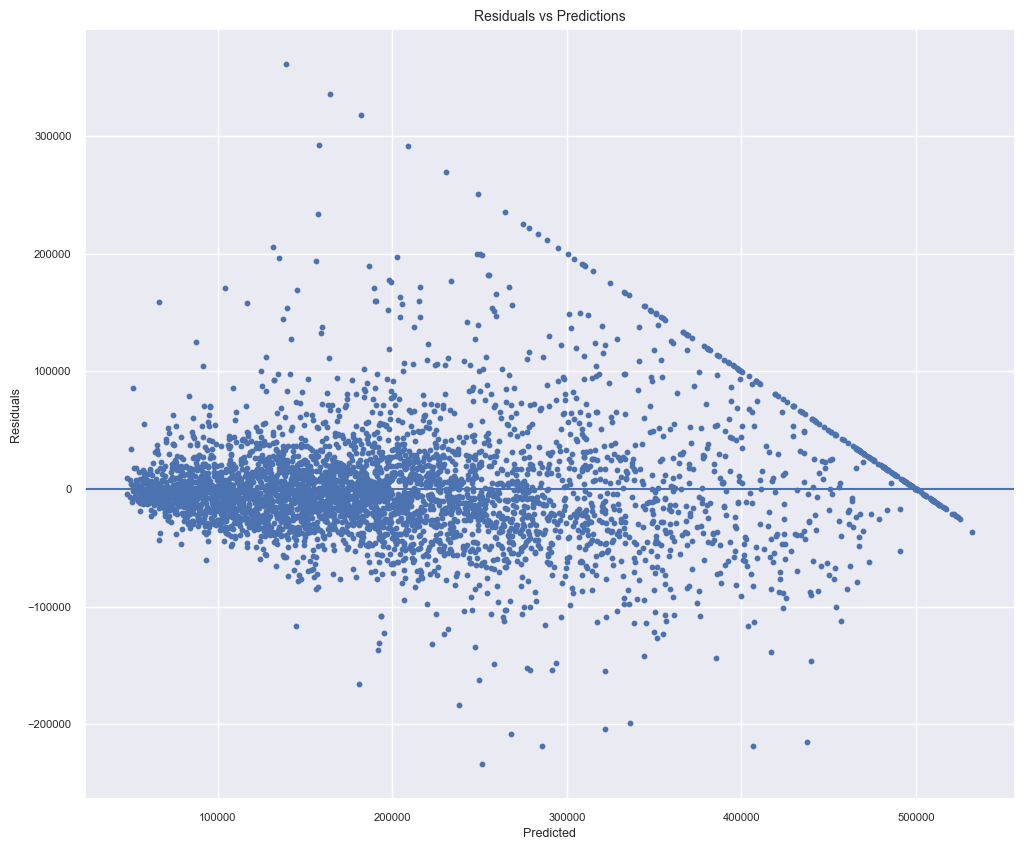

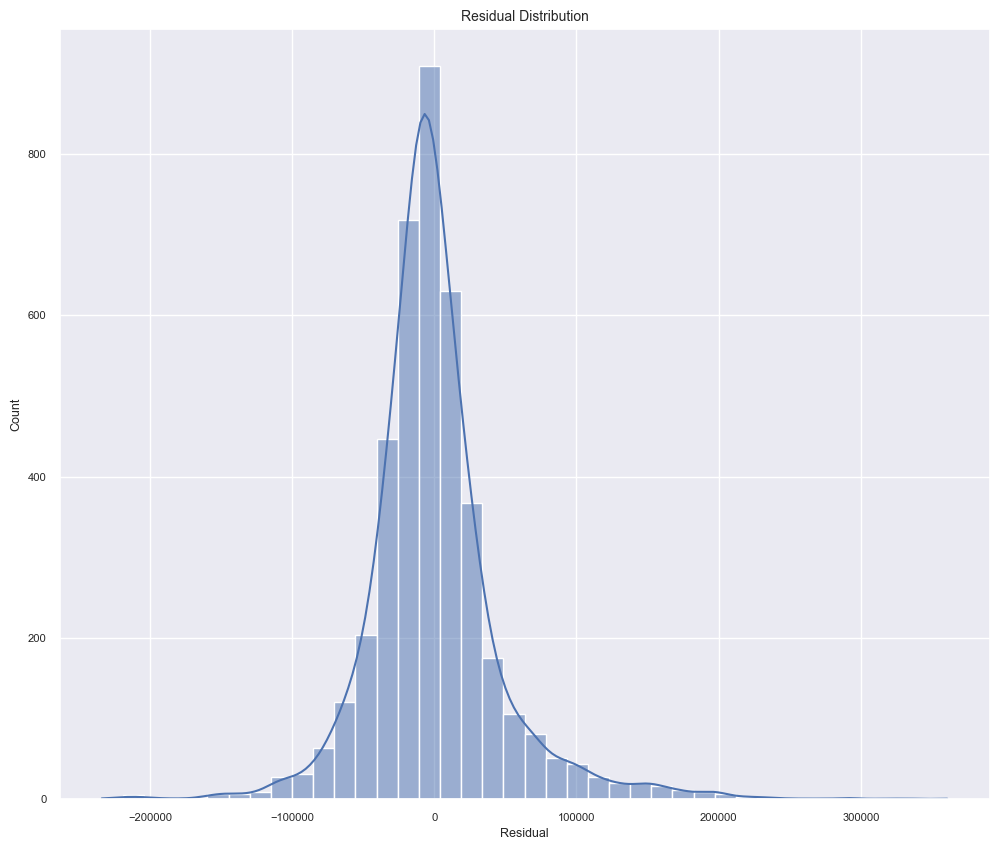

In [58]:
# residual plot
residuals = y_test - test_final_pred

plt.figure(figsize=(12, 10))
plt.scatter(test_final_pred, residuals, s=10)
plt.axhline(0)
plt.title("Residuals vs Predictions")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

plt.figure(figsize=(12, 10))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

In [59]:
def predict_house_price(
    model,
    longitude: float,
    latitude: float,
    housing_median_age: float,
    total_rooms: float,
    total_bedrooms: float,
    population: float,
    households: float,
    median_income: float,
    ocean_proximity: str
) -> float:
    """
    Predict median_house_value for one new house.
    total_bedrooms can be np.nan (pipeline will impute).
    """
    new_row = pd.DataFrame([{
        "longitude": longitude,
        "latitude": latitude,
        "housing_median_age": housing_median_age,
        "total_rooms": total_rooms,
        "total_bedrooms": total_bedrooms,
        "population": population,
        "households": households,
        "median_income": median_income,
        "ocean_proximity": ocean_proximity
    }])

    return float(model.predict(new_row)[0])

In [60]:
# Example inference
example_pred = predict_house_price(
    model=hgb_best,
    longitude=-122.230,
    latitude=37.880,
    housing_median_age=41,
    total_rooms=880,
    total_bedrooms=129,
    population=322,
    households=126,
    median_income=8.3252,
    ocean_proximity="NEAR BAY"
 )

print("\nExample prediction:", round(example_pred, 2))


Example prediction: 474106.84


**📈 Ways to improve performance**

- Create ratio features
    - rooms_per_household
    - bedrooms_per_room
    - population_per_household
- Try log transformation on the target variable.
- Tune max_iter and max_bins for HistGradientBoosting.
- Try advanced boosting models like XGBoost or LightGBM.
- Do error analysis by location or price ranges instead of only metrics.
- Use spatial or grouped validation for location-based data.

In [61]:
import joblib

joblib.dump(hgb_best, "housing_price_model.pkl")

['housing_price_model.pkl']

In [62]:
import sklearn
print(sklearn.__version__)

1.7.2
